# Mean comparisons using the FISH data

Data: https://drive.google.com/drive/folders/1uos3DDymyrh3ZyxveDhqQIcOyD1brxeL

In [1]:
import pandas as pd
import scanpy as sc
import seaborn as sns
import scanpy as sc
import scipy.sparse as sparse
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy.optimize as opt
import itertools

In [2]:
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", ['turquoise', 'slategrey', 'silver', 'lightsteelblue'])


In [3]:
data_path = '/home/ubuntu/Data/saver/'

### Read Dropseq data

In [4]:
dropseq_adata = sc.read(data_path + 'full_dropseq.h5ad')
# sc.pp.subsample(dropseq_adata, n_obs=1000)
print(dropseq_adata.shape)
# Filter cells without GAPDH
# dropseq_adata = dropseq_adata[dropseq_adata[:, 'GAPDH'].X.todense().A1 > 0].copy()
dropseq_adata = dropseq_adata[dropseq_adata.X.sum(axis=1).A1 > 0].copy()

print(dropseq_adata.shape)
dropseq_adata.obs['n_counts'] = dropseq_adata.X.sum(axis=1).A1
dropseq_adata.obs['n_genes'] = (dropseq_adata.X > 0).sum(axis=1).A1



/home/ubuntu/anaconda3/envs/mementocxg/lib/python3.11/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


(8498, 32287)
(8498, 32287)


### Read smFISH data

In [5]:
z_means = dropseq_adata.X.mean(axis=0).A1

In [24]:
dropseq_genes = dropseq_adata.var.index[z_means > 0.01].tolist()

In [25]:
smfish = pd.read_csv(data_path + 'fishSubset.txt', index_col=0, sep=' ')
overlap_genes = list(set(dropseq_genes) & set(smfish.columns))

In [26]:
len(overlap_genes)

15

### Recreate mean agreement from Torre et al

In [283]:
# filtered_fish = smfish.query('GAPDH > 0')

mean_fish = (filtered_fish[overlap_genes]/(filtered_fish['GAPDH']).values.reshape(-1,1)).mean(axis=0)*400

In [284]:
def bincount2d(arr, bins=None):
    if bins is None:
        bins = np.max(arr) + 1
    count = np.zeros(shape=[len(arr), bins], dtype=np.int64)
    indexing = (np.ones_like(arr).T * np.arange(len(arr))).T
    np.add.at(count, (indexing, arr), 1)

    return count

def bincount2d_sparse(sparse_arr, bins=None):

    bins = np.round(sparse_arr.max()).astype(int) + 1
    num_cells, num_genes = sparse_arr.shape
    count = sparse.lil_matrix((num_cells, bins))
    for cell in range(num_cells):
        cell_counts = np.bincount(np.round(sparse_arr[cell].data).astype(int))
        cell_counts[0] = num_genes - sparse_arr[cell].nnz
        count[cell, np.arange(cell_counts.shape[0])] = cell_counts
    return count

In [285]:
filtered_adata = dropseq_adata#[dropseq_adata[:, 'GAPDH'].X.todense() > 0]


In [286]:
data = filtered_adata.X.copy()

In [287]:
freqs = bincount2d_sparse(data)
expected_freqs = freqs.mean(axis=0).A1
mask = (data.data < 10).astype(bool)
data.data[mask] = data.data[mask]*expected_freqs[(data.data[mask]+1).astype(int)]/expected_freqs[data.data[mask].astype(int)]

In [288]:
pseudobulk = (filtered_adata.X.sum(axis=0).A1+1)
avg_zero_gene_counts = np.mean([pseudobulk[data[cell].nonzero()[1]].sum() for cell in range(data.shape[0])])

In [289]:
# arr = np.round(filtered_adata.X.toarray()).astype(int)
# smooth_arr = arr.copy().astype(np.float64)

# smooth_mask = (arr < 10)
# smooth_arr[smooth_mask] = (arr[smooth_mask]+1)*expected_freqs[arr[smooth_mask]+1] / expected_freqs[arr[smooth_mask]]



# smooth_mask = (arr == 0)
# pb = (filtered_adata.X.sum(axis=0).A1+1)
# denom = np.array([10127713.090762554 for i in range(smooth_mask.shape[0])])
# alpha=0.9
# smooth_arr[smooth_mask] = expected_freqs[1]*(alpha*(pb[np.where(smooth_mask)[1]]/10127713.090762554) + ((1-alpha)/expected_freqs[0]))
# smooth_mean = (smooth_arr/filtered_adata.X.sum(axis=1)).mean(axis=0).A1
# smooth_mean_dropseq = pd.Series(smooth_mean, index=filtered_adata.var.index)
# smooth_mean_dropseq *= 400/smooth_mean_dropseq['GAPDH']
# smooth_mean_dropseq = smooth_mean_dropseq[overlap_genes]

In [290]:
# def _mean_only_shrink(data, n_obs, q, size_factor=None):
#     """
#         Hypergeometric mean estimator based on Good's estimator.
#     """

#     if type(data) == tuple:
#         pass
#     else:
        
    


In [291]:
import copy

In [292]:
filtered_adata = dropseq_adata#[dropseq_adata[:, 'GAPDH'].X.todense() > 0]

# Normalmean
mean_dropseq = pd.Series(
    (filtered_adata[:, overlap_genes].X/filtered_adata.X.sum(axis=1)).mean(axis=0).A1,
    index=overlap_genes)
mean_dropseq *= 400/mean_dropseq['GAPDH']

# Pseudobulk "mean"
pb_mean_dropseq = pd.Series(
    filtered_adata[:, overlap_genes].X.sum(axis=0).A1/filtered_adata.X.sum(),
    index=overlap_genes)
pb_mean_dropseq *= 400/pb_mean_dropseq['GAPDH']

# Filtering low coverage cells
temp =  filtered_adata[(filtered_adata.obs['n_counts']>1000), :]
large_cell_mean_dropseq = pd.Series(
   (temp[:,overlap_genes].X/temp.X.sum(axis=1)).mean(axis=0).A1,
    index=overlap_genes)
large_cell_mean_dropseq *= 400/large_cell_mean_dropseq['GAPDH']
large_cell_mean_dropseq = large_cell_mean_dropseq[large_cell_mean_dropseq >0]

# Shrinkage towards pseudobulk means
# alpha = 0.5
# shrinked_mean_dropseq = alpha*pb_mean_dropseq + (1-alpha)*mean_dropseq
# shrinked_mean_dropseq *= 400/shrinked_mean_dropseq['GAPDH']

# # pop
arr = np.round(filtered_adata.X.toarray()).astype(int)
smooth_arr = arr.copy().astype(np.float64)
freqs = bincount2d(arr)
expected_freqs = freqs.mean(axis=0)

smooth_mask = (arr < 10)
smooth_arr[smooth_mask] = (arr[smooth_mask]+1)*expected_freqs[arr[smooth_mask]+1] / expected_freqs[arr[smooth_mask]]
smooth_mask = (arr == 0)
pb = (filtered_adata.X.sum(axis=0).A1+1)
denom = np.array([10127713.090762554 for i in range(smooth_mask.shape[0])])
alpha=0.9
smooth_arr[smooth_mask] = expected_freqs[1]*(alpha*(pb[np.where(smooth_mask)[1]]/10127713.090762554) + ((1-alpha)/expected_freqs[0]))
smooth_mean = (smooth_arr/filtered_adata.X.sum(axis=1)).mean(axis=0).A1
smooth_mean_dropseq = pd.Series(smooth_mean, index=filtered_adata.var.index)
smooth_mean_dropseq *= 400/smooth_mean_dropseq['GAPDH']
smooth_mean_dropseq = smooth_mean_dropseq[overlap_genes]

# pb level Good estimator
captured_data = filtered_adata.X
pb = captured_data.sum(axis=0).A1.astype(int)

pb_freqs = pd.Series(pb).value_counts().sort_index()

r = pb_freqs.index.values
nr = pb_freqs.values

z = pd.Series(pb_freqs.index).rolling(window=3, center=True).apply(lambda x: x.iloc[-1]-x.iloc[0]).values
z[0] = 2
z[-1] = z[-2]
z = 2*nr/z

r_star = (r+1)*np.concatenate([z[1:], z[-1:]])/z




In [293]:
pb_star = pb.copy().astype(float)
for r_val in r[r < 10]:#r[(r > 0) & (r < 50)]:
    
    pb_star[pb == r_val] = r_star[np.where(r==r_val)[0]][0]

In [294]:
good_m = pb_star/pb.sum()

good_mean_dropseq = pd.Series(good_m, index=filtered_adata.var.index)
good_mean_dropseq *= 400/good_mean_dropseq['GAPDH']
good_mean_dropseq = good_mean_dropseq[overlap_genes]

In [295]:
print('sample mean',stats.pearsonr(np.log10(mean_fish[large_cell_mean_dropseq.index]), np.log10(mean_dropseq[large_cell_mean_dropseq.index])))
print('pb', stats.pearsonr(np.log10(mean_fish[large_cell_mean_dropseq.index]), np.log10(pb_mean_dropseq[large_cell_mean_dropseq.index])))
print('large cell', stats.pearsonr(np.log10(mean_fish[large_cell_mean_dropseq.index]), np.log10(large_cell_mean_dropseq)))
# print('shrinked mean',stats.pearsonr(np.log10(mean_fish[large_cell_mean_dropseq.index]), np.log10(shrinked_mean_dropseq[large_cell_mean_dropseq.index])))
print('smooth mean',stats.pearsonr(np.log10(mean_fish[large_cell_mean_dropseq.index]), np.log10(smooth_mean_dropseq[large_cell_mean_dropseq.index])))
print('good mean',stats.pearsonr(np.log10(mean_fish[large_cell_mean_dropseq.index]), np.log10(good_mean_dropseq[large_cell_mean_dropseq.index])))


sample mean PearsonRResult(statistic=0.532700527306649, pvalue=0.027695543981998475)
pb PearsonRResult(statistic=0.5298306048992905, pvalue=0.02870592424407839)
large cell PearsonRResult(statistic=0.5360296979230607, pvalue=0.026558090334194605)
smooth mean PearsonRResult(statistic=0.5301849092315196, pvalue=0.028579675379999604)
good mean PearsonRResult(statistic=0.5294539619653513, pvalue=0.02884060351529764)


In [296]:
print('sample mean',stats.spearmanr(np.log10(mean_fish[large_cell_mean_dropseq.index]), np.log10(mean_dropseq[large_cell_mean_dropseq.index])))
print('pb', stats.spearmanr(np.log10(mean_fish[large_cell_mean_dropseq.index]), np.log10(pb_mean_dropseq[large_cell_mean_dropseq.index])))
print('large cell', stats.spearmanr(np.log10(mean_fish[large_cell_mean_dropseq.index]), np.log10(large_cell_mean_dropseq)))
# print('shrinked mean',stats.pearsonr(np.log10(mean_fish[large_cell_mean_dropseq.index]), np.log10(shrinked_mean_dropseq[large_cell_mean_dropseq.index])))
print('smooth mean',stats.spearmanr(np.log10(mean_fish[large_cell_mean_dropseq.index]), np.log10(smooth_mean_dropseq[large_cell_mean_dropseq.index])))
print('good mean',stats.spearmanr(np.log10(mean_fish[large_cell_mean_dropseq.index]), np.log10(good_mean_dropseq[large_cell_mean_dropseq.index])))


sample mean SignificanceResult(statistic=0.5588235294117647, pvalue=0.01970856591580171)
pb SignificanceResult(statistic=0.5588235294117647, pvalue=0.01970856591580171)
large cell SignificanceResult(statistic=0.5588235294117647, pvalue=0.01970856591580171)
smooth mean SignificanceResult(statistic=0.5588235294117647, pvalue=0.01970856591580171)
good mean SignificanceResult(statistic=0.5588235294117647, pvalue=0.01970856591580171)


In [297]:
observed_mean = dropseq_adata[:, overlap_genes].X.mean(axis=0).A1

In [298]:
observed_mean

array([5.95434220e-02, 2.02400565e-02, 5.96728642e-01, 1.01718051e+00,
       1.44739939e+00, 1.04730525e-01, 3.61261473e-02, 7.16639209e-02,
       1.36502707e-02, 7.55471876e-02, 2.63591433e-01, 5.17768887e-03,
       1.54036244e-01, 7.86290892e+00, 3.19251589e-01, 1.90750765e-01,
       9.41397976e-03])

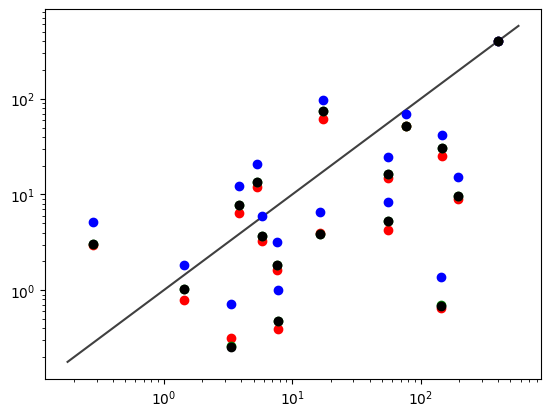

In [299]:
fig, ax = plt.subplots()

gene_filter = observed_mean > 0.005

ax.scatter(mean_fish[gene_filter], mean_dropseq[gene_filter], color='r')
ax.scatter(mean_fish[gene_filter], pb_mean_dropseq[gene_filter], color='g')
ax.scatter(mean_fish[gene_filter], smooth_mean_dropseq[gene_filter], color='b')
ax.scatter(mean_fish[gene_filter], good_mean_dropseq[gene_filter], color='k')


ax.set_xscale('log')
ax.set_yscale('log')

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)

In [194]:
x = dropseq_adata[:, 'AXL'].X.toarray().reshape(-1)

In [195]:
x[ x > 0]

array([1., 1.])

(array([8.496e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

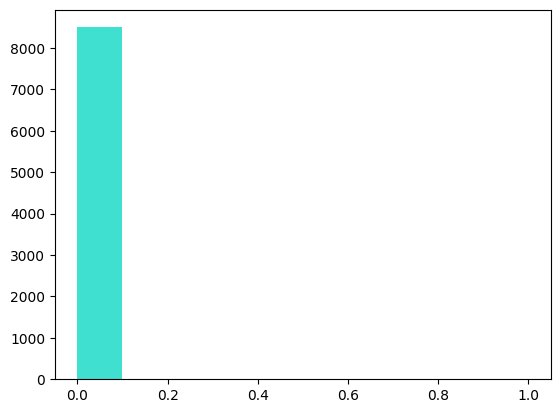

In [196]:
plt.hist(dropseq_adata[:, 'AXL'].X.toarray().reshape(-1))


In [181]:
mean_dropseq.sort_values()

SERPINE1      0.026866
VEGFC         0.027979
AXL           0.028040
PDGFRB        0.037031
NGFR          0.037968
LOXL2         0.078336
WNT5A         0.082140
NRG1          0.101628
PDGFC         0.149821
EGFR          0.314844
JUN           0.390560
C1S           0.649765
RUNX2         0.792655
FGFR1         1.626001
FOSL1         2.989434
BABAM1        3.298394
CCNA2         3.990976
VCL           4.262069
KDM5B         6.443487
SOX10         9.039734
KDM5A        11.959837
TXNRD1       14.945017
LMNA         25.144209
MITF         51.702299
VGF          61.889047
GAPDH       400.000000
dtype: float64

In [29]:
mean_fish.shape

(26,)

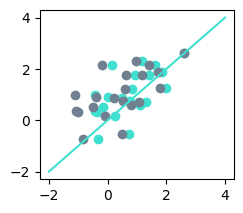

In [141]:
plt.figure(figsize=(2.5,2.2))
# plt.scatter(mean_fish, mean_dropseq)
# plt.scatter(mean_fish, pb_mean_dropseq)
plt.scatter(np.log10(smooth_mean_dropseq), np.log10(mean_fish))
plt.scatter(np.log10(mean_dropseq), np.log10(mean_fish))


plt.plot([-2, 4], [-2, 4])

# corr = stats.pearsonr(np.log10(mean_fish), np.log10(mean_dropseq))
# plt.yscale('log')
# plt.xscale('log')
# plt.xlabel('smFISH mean'); plt.ylabel('Dropseq mean');
plt.savefig('mean_fish.pdf', bbox_inches='tight')
# plt.title(f'R = {corr[0]:0.2f}, P = {corr[1]:0.4f}');

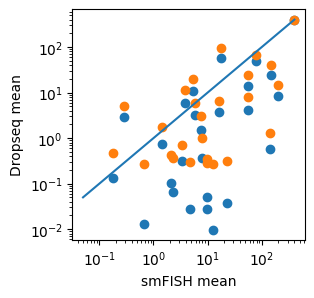

In [11]:
plt.figure(figsize=(3,3))
# plt.scatter(mean_fish, mean_dropseq)
plt.scatter(mean_fish, mean_dropseq)
plt.scatter(mean_fish, smooth_mean_dropseq)

plt.plot([0.05, 400], [0.05, 400])

# corr = stats.pearsonr(np.log10(mean_fish), np.log10(mean_dropseq))
plt.yscale('log')
plt.xscale('log')
plt.xlabel('smFISH mean'); plt.ylabel('Dropseq mean');
# plt.title(f'R = {corr[0]:0.2f}, P = {corr[1]:0.4f}');

In [ ]:
np.bincount(np.round(filtered_adata[:, 'FOSL1'].X.todense().A1).astype(int))

In [ ]:
smooth_mean_dropseq

In [ ]:
pb_mean_dropseq

In [ ]:
mean_fish

In [ ]:
plt.figure(figsize=(3,3))
plt.scatter(mean_fish, smooth_mean_dropseq)
corr = stats.pearsonr(np.log10(mean_fish), np.log10(smooth_mean_dropseq))
plt.yscale('log')
plt.xscale('log')
plt.xlabel('smFISH mean'); plt.ylabel('Dropseq mean');
plt.title(f'R = {corr[0]:0.2f}, P = {corr[1]:0.4f}');

ValueError: x and y must have length at least 2.

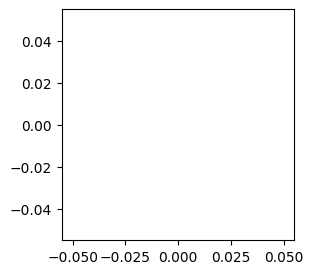

In [110]:
plt.figure(figsize=(3,3))
plt.scatter(mean_fish[gene_filter_mean_dropseq.index], gene_filter_mean_dropseq)
corr = stats.pearsonr(np.log10(mean_fish[gene_filter_mean_dropseq.index]), np.log10(gene_filter_mean_dropseq))
plt.yscale('log')
plt.xscale('log')
plt.xlabel('smFISH mean'); plt.ylabel('Dropseq mean');
plt.title(f'R = {corr[0]:0.2f}, P = {corr[1]:0.4f}');

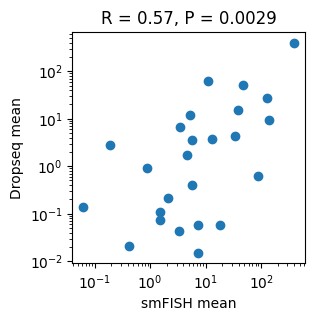

In [11]:
plt.figure(figsize=(3,3))
plt.scatter(mean_fish[large_cell_mean_dropseq.index], large_cell_mean_dropseq)
corr = stats.pearsonr(np.log10(mean_fish[large_cell_mean_dropseq.index]), np.log10(large_cell_mean_dropseq))
plt.yscale('log')
plt.xscale('log')
plt.xlabel('smFISH mean'); plt.ylabel('Dropseq mean');
plt.title(f'R = {corr[0]:0.2f}, P = {corr[1]:0.4f}');

ValueError: x and y must be the same size

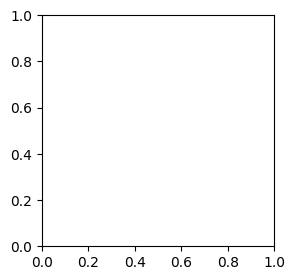

In [95]:
plt.figure(figsize=(3,3))
plt.scatter(mean_fish, mean_dropseq)
corr = stats.pearsonr(np.log10(mean_fish), np.log10(mean_dropseq))
plt.yscale('log')
plt.xscale('log')
plt.xlabel('smFISH mean'); plt.ylabel('Dropseq mean');
plt.title(f'R = {corr[0]:0.2f}, P = {corr[1]:0.4f}');

### Cell size weighting

In [8]:
filtered_adata = dropseq_adata#[dropseq_adata[:, 'GAPDH'].X.todense() > 0]
cw_mean_dropseq = pd.Series(
    filtered_adata[:, overlap_genes].X.sum(axis=0).A1/filtered_adata.obs['n_counts'].sum(),
    index=overlap_genes)
cw_mean_dropseq *= 400/cw_mean_dropseq['GAPDH']

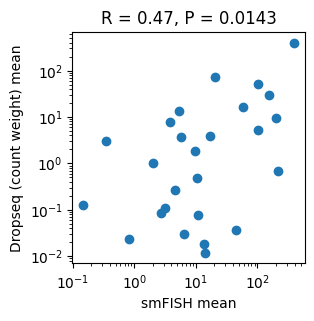

In [9]:
plt.figure(figsize=(3,3))
plt.scatter(mean_fish, cw_mean_dropseq)
corr = stats.pearsonr(np.log10(mean_fish), np.log10(cw_mean_dropseq))
plt.yscale('log')
plt.xscale('log')
plt.xlabel('smFISH mean'); plt.ylabel('Dropseq (count weight) mean');
plt.title(f'R = {corr[0]:0.2f}, P = {corr[1]:0.4f}');

### Inverse variance weighting

In [10]:
p_hat = (filtered_adata[:, overlap_genes].X.todense()+1)/filtered_adata.obs[['n_counts']].values

In [11]:
size_factor = filtered_adata.obs[['n_counts']].values

In [12]:
weights = 1/(np.multiply(p_hat, 1-p_hat)/ (size_factor/size_factor.mean()) )

In [13]:
iw_mean_dropseq = np.average( 
    (filtered_adata[:, overlap_genes].X.todense())/filtered_adata.obs[['n_counts']].values,
    weights=weights,
    axis=0).A1
iw_mean_dropseq = pd.Series(iw_mean_dropseq, index=overlap_genes)
iw_mean_dropseq *= 400/iw_mean_dropseq['GAPDH']

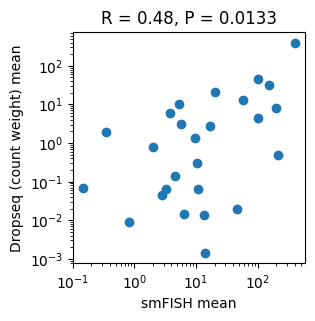

In [14]:
plt.figure(figsize=(3,3))
plt.scatter(mean_fish, iw_mean_dropseq)
corr = stats.pearsonr(np.log10(mean_fish), np.log10(iw_mean_dropseq))
plt.yscale('log')
plt.xscale('log')
plt.xlabel('smFISH mean'); plt.ylabel('Dropseq (count weight) mean');
plt.title(f'R = {corr[0]:0.2f}, P = {corr[1]:0.4f}');

### Function for comparing estimators using FISH data

In [28]:
def compare_estimators(smfish, fish_gapdh_sf, dropseq, dropseq_sf, overlap_genes,p=1):

    q=0.02*p
    mfish = (smfish/fish_gapdh_sf.reshape(-1,1))[overlap_genes].mean(axis=0)

    # Sample mean
    m1 = (dropseq/dropseq_sf.reshape(-1,1))[overlap_genes].mean(axis=0)

    # Filtering cells
    cells_with_many_genes = (dropseq_sf > 1500*p)
    m2 = (dropseq/dropseq_sf.reshape(-1,1)).loc[cells_with_many_genes,overlap_genes].mean(axis=0)
    m2 = np.maximum(m1,m2)

    # Solve for optimal weights
    X = dropseq/dropseq_sf.reshape(-1,1)
    naive_v = X.var(axis=0)[overlap_genes]
    v = naive_v-(1-q)*(dropseq[overlap_genes].values/(dropseq_sf**2-dropseq_sf*(1-q)).reshape(-1,1)).mean(axis=0)
    variance_contributions = ((1-q)/dropseq_sf).reshape(-1,1)*m1.values.reshape(1,-1) + v.values.reshape(1,-1)
    m3 = pd.Series(np.average( (dropseq/dropseq_sf.reshape(-1,1))[overlap_genes], weights=1/variance_contributions, axis=0), index=m2.index)
    m3[m3<0] = m2[m3<0]
    
    return mfish, m1, m2, m3

### Using all cells

In [32]:
filtered_adata

AnnData object with n_obs × n_vars = 8498 × 32287
    obs: 'n_counts'

In [33]:
dropseq_pd = pd.DataFrame(filtered_adata.X.todense(), index=filtered_adata.obs.index, columns=filtered_adata.var.index)

In [38]:
mfish, m1, m2, m3 = compare_estimators(
    smfish, 
    (filtered_fish['GAPDH']+1).values, 
    dropseq_pd, 
    filtered_adata.X.sum(axis=1).A1, 
    overlap_genes,p=1)
viz_mfish = mfish*400
viz_m1 = (400/m1['GAPDH'])*m1
viz_m2 = (400/m1['GAPDH'])*m2
viz_m3 = (400/m3['GAPDH'])*m3
print('sample mean', stats.pearsonr(
    np.log(viz_mfish),
    np.log(viz_m1)))
print('filtering cells', stats.pearsonr(
    np.log(viz_mfish),
    np.log(viz_m2)))
print('memento', stats.pearsonr(
    np.log(viz_mfish),
    np.log(viz_m3)))

sample mean PearsonRResult(statistic=0.4810880405432051, pvalue=0.012843673741249742)
filtering cells PearsonRResult(statistic=0.4713124771834473, pvalue=0.015078893943004237)
memento PearsonRResult(statistic=0.4729332350023358, pvalue=0.014687608546246535)


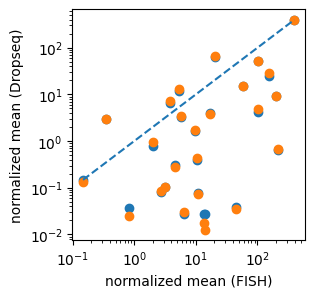

In [35]:
plt.figure(figsize=(3,3))
plt.scatter(viz_mfish, viz_m1)
plt.scatter(viz_mfish, viz_m3)

plt.plot([viz_mfish.min(), viz_mfish.max()], [viz_mfish.min(), viz_mfish.max()], '--')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('normalized mean (FISH)');plt.ylabel('normalized mean (Dropseq)');

### Only using 50 cells

In [235]:
%%capture --no-stdout
m1s = []
m3s = []

corrs = []
for trial in range(1000):
    

    # with warnings.catch_warnings():
    #     warnings.simplefilter("error")


    cell_selector = np.random.choice(dropseq.shape[0], 100)
    small = dropseq.iloc[cell_selector]
    small_sf = dropseq_sf[cell_selector]

    mfish, m1, m2, m3 = compare_estimators(smfish, fish_gapdh_sf, small, small_sf, overlap_genes,p=1)
    
    viz_mfish = mfish*400
    viz_m1 = (400/m1['GAPDH'])*m1
    viz_m3 = (400/m3['GAPDH'])*m3

    overlap = list(set(m1[m1>0].index) &set(m3[m3>0].index))
    m1_corr = stats.pearsonr(
        np.log(viz_mfish[overlap]),
        np.log(viz_m1[overlap]))
    m3_corr = stats.pearsonr(
        np.log(viz_mfish[overlap]),
        np.log(viz_m3[overlap]))
    
    # print(m1_corr, m3_corr)
    
    
    corrs.append((m1_corr[0], m3_corr[0]))

corrs = pd.DataFrame(corrs, columns=['m1', 'm3'])
# m1 = pd.Series(np.vstack(m1s).mean(axis=0), index=smfish.columns)
# m1_std = np.vstack(m1s).std(axis=0)
# m3 = pd.Series(np.vstack(m3s).mean(axis=0), index=smfish.columns)
# m3_std = np.vstack(m3s).std(axis=0)


# print('sample mean', stats.pearsonr(
#                 np.log(viz_mfish),
#                 np.log(viz_m1)))
# print('memento', stats.pearsonr(
#     np.log(viz_mfish),
#     np.log(viz_m3)))

In [236]:
corrs['m1'].mean()

0.7094018438512671

In [237]:
corrs['m3'].mean()

0.7289802959726753

<Axes: xlabel='m1', ylabel='Density'>

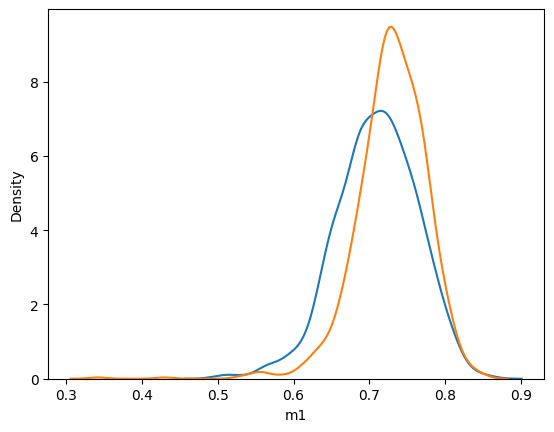

In [259]:
sns.kdeplot(corrs['m1'])
sns.kdeplot(corrs['m3'])

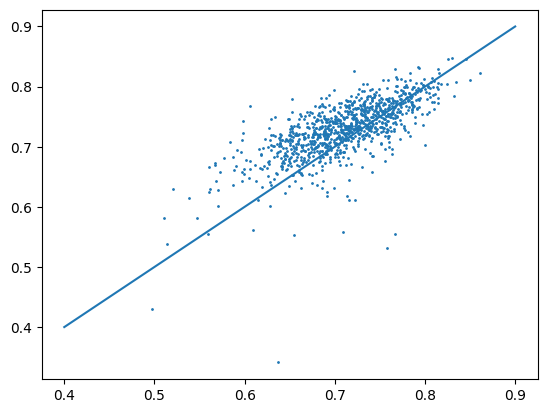

In [260]:
plt.scatter(corrs['m1'], corrs['m3'], s=1)
plt.plot([0.4, 0.9], [0.4, 0.9])
plt.

In [338]:
small.to_csv('small_for_fig.csv')

In [391]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", ['turquoise', 'slategrey', 'silver'])

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'small',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

PearsonRResult(statistic=0.7044440774753608, pvalue=0.0049111338851964125) PearsonRResult(statistic=0.7966298169755954, pvalue=0.0006486810082608935)


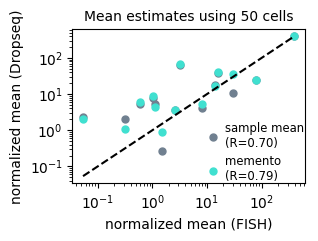

In [393]:
# cell_selector = np.random.choice(dropseq.shape[0], 100)
# small = dropseq.iloc[cell_selector]
# small_sf = dropseq_sf[cell_selector]

# mfish, m1, m2, m3 = compare_estimators(smfish, fish_gapdh_sf, small, small_sf, overlap_genes,p=1)

# viz_mfish = mfish*400
# viz_m1 = (400/m1['GAPDH'])*m1
# viz_m3 = (400/m3['GAPDH'])*m3

# overlap = list(set(m1[m1>0].index) &set(m3[m3>0].index))
# m1_corr = stats.pearsonr(
#     np.log(viz_mfish[overlap]),
#     np.log(viz_m1[overlap]))
# m3_corr = stats.pearsonr(
#     np.log(viz_mfish[overlap]),
#     np.log(viz_m3[overlap]))

print(m1_corr, m3_corr)

plt.figure(figsize=(3,2))
plt.scatter(viz_mfish, viz_m1, s=25, color='slategrey', label='sample mean\n(R=0.70)')
plt.scatter(viz_mfish, viz_m3, s=25, color='turquoise', label='memento\n(R=0.79)')

plt.plot([viz_mfish.min(), viz_mfish.max()], [viz_mfish.min(), viz_mfish.max()], '--', color='k')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('normalized mean (FISH)');plt.ylabel('normalized mean (Dropseq)');
plt.title('Mean estimates using 50 cells')
plt.legend(frameon=False, loc='center right', bbox_to_anchor=(1.04,0.2), handletextpad=0.01, ncols=1,  columnspacing=0.1)
plt.savefig('50_cell_means.pdf', bbox_inches='tight')

In [152]:
(corrs['m1']<corrs['m3']).mean()

0.707

In [140]:
corrs

,m1,m3
0,0.645613,0.670976
1,0.657286,0.676139
2,0.655133,0.718694
3,0.643156,0.672569
4,0.568119,0.578224
...,...,...
95,0.613361,0.617691
96,0.711499,0.652103
97,0.579959,0.649487
98,0.581797,0.723691


In [ ]:
%%capture --no-stderr

m1s = []
m3s = []

corrs = []
for trial in range(100):
    

    # with warnings.catch_warnings():
    #     warnings.simplefilter("error")


    cell_selector = np.random.choice(dropseq.shape[0], 50)
    small = dropseq.iloc[cell_selector]
    small_sf = dropseq_sf[cell_selector]

    mfish, m1, m2, m3 = compare_estimators(smfish, fish_gapdh_sf, small, small_sf, overlap_genes,p=1)
    
    viz_mfish = mfish*400
    viz_m1 = (400/m1['GAPDH'])*m1
    viz_m3 = (400/m3['GAPDH'])*m3

    m1s.append(m1)
    m3s.append(m3)
    
    m1_corr = stats.pearsonr(
        np.log(viz_mfish),
        np.log(viz_m1))
    m3_corr = stats.pearsonr(
        np.log(viz_mfish),
        np.log(viz_m3))
    corrs.append((m1_corr[0], m2_corr[0]))

    
# m1 = pd.Series(np.vstack(m1s).mean(axis=0), index=smfish.columns)
# m1_std = np.vstack(m1s).std(axis=0)
# m3 = pd.Series(np.vstack(m3s).mean(axis=0), index=smfish.columns)
# m3_std = np.vstack(m3s).std(axis=0)


# print('sample mean', stats.pearsonr(
#                 np.log(viz_mfish),
#                 np.log(viz_m1)))
# print('memento', stats.pearsonr(
#     np.log(viz_mfish),
#     np.log(viz_m3)))

In [133]:
corrs

[]

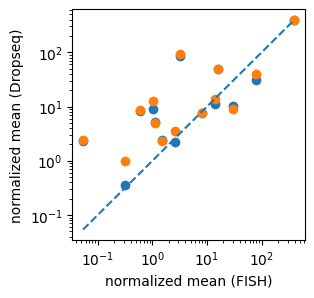

In [120]:
plt.figure(figsize=(3,3))
plt.scatter(viz_mfish, viz_m1)
plt.scatter(viz_mfish, viz_m3)

plt.plot([viz_mfish.min(), viz_mfish.max()], [viz_mfish.min(), viz_mfish.max()], '--')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('normalized mean (FISH)');plt.ylabel('normalized mean (Dropseq)');

### Investigate performance with varying number of cells

In [23]:
result = []
for num_cell in [50, 100, 200, 300, 500, 1000]:
        
        for trial in range(1000):

            sample_idx = np.random.choice(dropseq.shape[0], num_cell)
            tiny = dropseq.iloc[sample_idx]
            shallow = tiny
            counts = shallow.sum(axis=0)[overlap_genes]
            relevant_genes = counts[counts > 0].index.tolist()
            shallow_sf = shallow.sum(axis=1).values
            mfish, m1, m2, m3 = compare_estimators(smfish, fish_gapdh_sf, shallow, shallow_sf, overlap_genes=relevant_genes, p=1)

            mean_numi = shallow_sf.mean()
            
            corr1 = stats.pearsonr(np.log(mfish), np.log(m1))[0]
            corr2 = stats.pearsonr(np.log(mfish), np.log(m2))[0]
            corr3 = stats.pearsonr(np.log(mfish), np.log(m3))[0]
            result.append((num_cell, mean_numi, corr1, corr2, corr3, corr4))
experiment_result = pd.DataFrame(result, columns=['num_cell', 'mean_umi', 'naive', 'filtered', 'memento'])
# experiment_result.to_csv('numcells.csv', index=False)

In [18]:
scvi_result = []
mfish = (smfish/fish_gapdh_sf.reshape(-1,1))[overlap_genes].mean(axis=0)
for num_cell in [50, 100, 200, 300, 500, 1000]:
        
        for trial in range(10):
            
            print(num_cell, trial)
            sample_idx = np.random.choice(dropseq.shape[0], num_cell)
            tiny = dropseq.iloc[sample_idx]
            shallow = tiny
            shallow_sf = shallow.sum(axis=1).values
            mean_numi = shallow_sf.mean()
            
            adata = sc.AnnData(X=shallow.values, obs=pd.DataFrame(index=shallow.index), var=pd.DataFrame(index=shallow.columns))
            scvi.model.SCVI.setup_anndata(
                adata,
                categorical_covariate_keys=[],
                continuous_covariate_keys=[],
            )
            model = scvi.model.SCVI(adata)
            model.train()
            scvi_denoised = model.get_normalized_expression(library_size=10e4).mean(axis=0)
            
            corr1 = stats.pearsonr(np.log(mfish), np.log(scvi_denoised[overlap_genes]))[0]
            scvi_result.append((num_cell, mean_numi, corr1))


scvi_result = pd.DataFrame(scvi_result, columns=['num_cell', 'mean_umi', 'scvi'])
scvi_result.to_csv('numcells_scvi.csv', index=False)

In [4]:
experiment_result = pd.read_csv('numcells.csv').rename(columns={'naive':'sample mean\n(pseudobulk, SAVER,\nBASiCs, Zhang2018)'})
scvi_result= pd.melt(pd.read_csv(data_path + 'numcells_scvi.csv'), id_vars=['num_cell', 'mean_umi'], value_vars=['scvi'], var_name='estimator')
df = pd.melt(experiment_result, id_vars=['num_cell', 'mean_umi'], value_vars=['memento','sample mean\n(pseudobulk, SAVER,\nBASiCs, Zhang2018)'], var_name='estimator')

In [5]:
df = pd.concat([df, scvi_result])

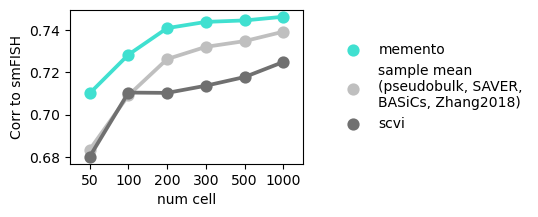

In [21]:
plt.figure(figsize=(3, 2))
pal = [(64/255,224/255,208/255)]+[sns.color_palette("Greys", 10)[3], sns.color_palette("Greys", 10)[6], ]
sns.pointplot(y='value', x='num_cell', hue='estimator',data=df, errorbar=('ci', 0), estimator='median', palette=pal)
plt.xlabel('num cell');plt.ylabel('Corr to smFISH')
# sns.stripplot(y='value', x='p', hue='estimator',data=df, dodge=True, alpha=0.2,s=3)
plt.legend(frameon=False, loc='center right', bbox_to_anchor=(2,0.5))
plt.savefig('estimation.pdf', bbox_inches='tight')

In [28]:
sample_idx = np.random.choice(dropseq.shape[0], 50)
tiny = dropseq.iloc[sample_idx]
shallow = tiny
counts = shallow.sum(axis=0)[overlap_genes]
relevant_genes = counts[counts > 0].index.tolist()
shallow_sf = shallow.sum(axis=1).values
mfish, m1, m2, m3 = compare_estimators(smfish, fish_gapdh_sf, shallow, shallow_sf, overlap_genes=relevant_genes, p=1)


Text(0, 0.5, 'fish')

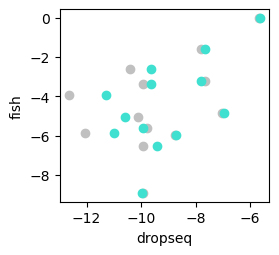

In [44]:
plt.figure(figsize=(2.7,2.5))
plt.scatter(np.log(m1), np.log(mfish), color='silver')
plt.scatter(np.log(m3), np.log(mfish), color='turquoise')
plt.xlabel('dropseq'); plt.ylabel('fish')

Text(0, 0.5, 'fish')

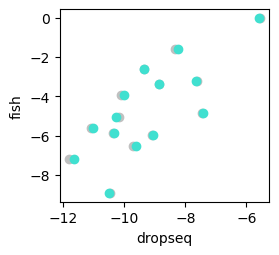

In [46]:
counts = dropseq.sum(axis=0)[overlap_genes]
relevant_genes = counts[counts > 0].index.tolist()
mfish, m1, m2, m3 = compare_estimators(smfish, fish_gapdh_sf, dropseq, dropseq_sf, overlap_genes=relevant_genes, p=1)
plt.figure(figsize=(2.7,2.5))

plt.scatter(np.log(m1), np.log(mfish), color='silver')
plt.scatter(np.log(m3), np.log(mfish), color='turquoise')
plt.xlabel('dropseq'); plt.ylabel('fish')

In [47]:
dropseq.shape

(8498, 12241)

In [10]:
m1

KDM5B     0.000061
VCL       0.000041
MITF      0.000492
BABAM1    0.000031
FOSL1     0.000028
LMNA      0.000239
TXNRD1    0.000142
FGFR1     0.000015
VGF       0.000589
RUNX2     0.000008
GAPDH     0.003803
SOX10     0.000086
CCNA2     0.000038
KDM5A     0.000114
dtype: float64

In [187]:
plt.scatter(np.log(mfish), np.log(m1*mmfish/mm1))
# plt.scatter(np.log(mfish), np.log(m2))
plt.scatter(np.log(mfish), np.log(m3*mmfish/mm3))
# plt.scatter(np.log(mfish), np.log(m4))

plt.xlabel('FISH'); plt.ylabel('Dropseq');
plt.legend(['naive r=%0.2f' % stats.pearsonr(np.log(mfish), np.log(m1*mmfish/mm1))[0], 
            # 'filtered r=%0.2f' %stats.pearsonr(np.log(mfish), np.log(m2))[0], 
            'weighted r=%0.2f' %stats.pearsonr(np.log(mfish), np.log(m3*mmfish/mm3))[0],
            # 'medofmean r=%0.2f' %stats.pearsonr(np.log(mfish), np.log(m4))[0] 
           ])

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


NameError: name 'mm1' is not defined

/tmp/ipykernel_22844/300944203.py:4: RuntimeWarning: invalid value encountered in log
  plt.scatter(np.log(mfish), np.log(m4))


ValueError: array must not contain infs or NaNs

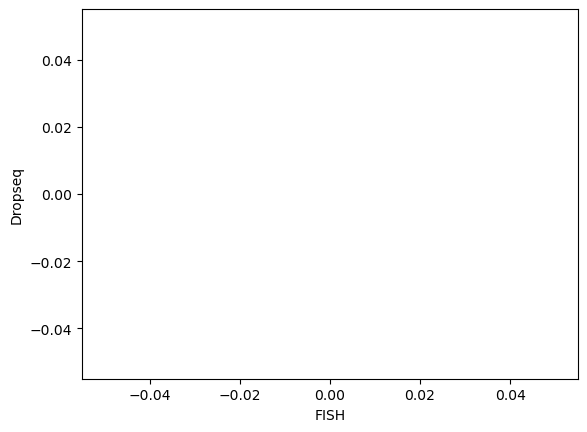

In [188]:
plt.scatter(np.log(mfish), np.log(m1))
plt.scatter(np.log(mfish), np.log(m2))
# plt.scatter(np.log(mfish), np.log(m3))
plt.scatter(np.log(mfish), np.log(m4))

plt.xlabel('FISH'); plt.ylabel('Dropseq');
plt.legend(['naive r=%0.2f' % stats.pearsonr(np.log(mfish), np.log(m1))[0], 
            'filtered r=%0.2f' %stats.pearsonr(np.log(mfish), np.log(m2))[0], 
            'medofmean r=%0.2f' %stats.pearsonr(np.log(mfish), np.log(m4))[0] ])

### Test with simple generative model

In [181]:
Nc = dropseq_sf/0.05
Mc = dropseq_sf

In [199]:
sampling_dist1 = np.zeros(5000)
for trial in range(5000):
    Z = stats.poisson.rvs(Nc*1e-5, size=Nc.shape[0])
    Y = stats.binom.rvs(Z, 0.05)
    estimate1 = (Y/Mc).mean()
    sampling_dist1[trial] = estimate1

In [200]:
sampling_dist1.mean()

9.994229215738449e-06

<AxesSubplot: ylabel='Density'>

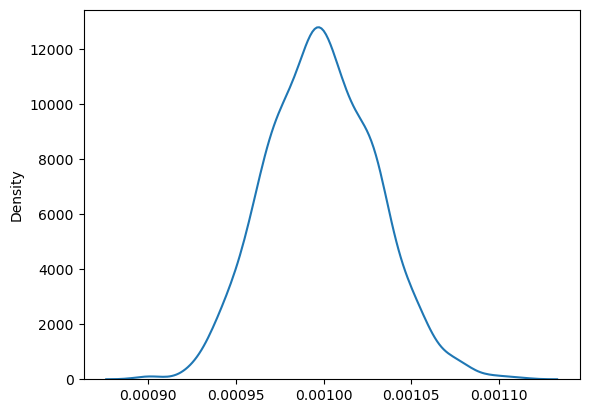

In [155]:
sns.kdeplot(sampling_dist1)

In [152]:
estimate = (Y/Mc).mean()

In [153]:
estimate

0.0009475896876039991

### Run memento for DropSeq

In [9]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.9-py3.8.egg')
sys.path.append('/home/ssm-user/Github/misc-seq/miscseq/')
import encode
import memento

In [53]:
adata = sc.AnnData(X=sparse.csr_matrix(dropseq.values), obs=pd.DataFrame(index=dropseq.index), var=pd.DataFrame(index=dropseq.columns))
q = 0.01485030176341905
adata.obs['q'] = q
adata.obs['group'] = 'A'
adata.write(data_path + 'dropseq.h5ad')

memento.setup_memento(adata, q_column='q', filter_mean_thresh=0.02,trim_percent=0.5, shrinkage=0)

#Optional
mem_gapdh_sf = (adata[:, 'GAPDH'].X.todense().A1+1)/( adata[:, 'GAPDH'].X.todense().A1+1).mean()
mem_total_sf = adata.obs['memento_size_factor']/adata.obs['memento_size_factor'].mean()
adata.obs['memento_size_factor'] = 1

memento.create_groups(adata, label_columns=['group'])
memento.compute_1d_moments(adata, filter_genes=True)

dropseq_m, dropseq_v, _ = adata.uns['memento']['1d_moments']['sg^A']
dropseq_fano = dropseq_v/dropseq_m**2

naive_sf = dropseq.sum(axis=1).values/adata.X.sum(axis=1).mean()
naive_sf = 1# adata.obs['memento_size_factor'].values

normalized_dropseq = adata.X.toarray()/naive_sf
naive_m, naive_v = normalized_dropseq.mean(axis=0), normalized_dropseq.var(axis=0)
naive_fano = naive_v/naive_m**2

... storing 'group' as categorical
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


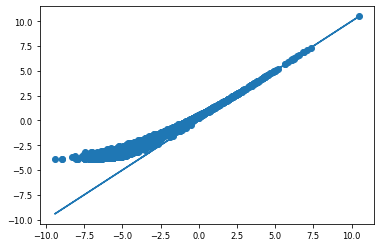

In [54]:
plt.scatter(np.log(dropseq_v), np.log(naive_v))
plt.plot(np.log(dropseq_v),np.log(dropseq_v))

### Compute fish mean and variance

In [55]:
keep_genes = smfish.columns.tolist()
overlap_genes = list(set(adata.var.index) & set(keep_genes))
overlap_gene_idxs = np.array([adata.var.index.tolist().index(g) for g in overlap_genes])

dropseq_m, dropseq_v, naive_m, naive_v = dropseq_m[overlap_gene_idxs], dropseq_v[overlap_gene_idxs], naive_m[overlap_gene_idxs], naive_v[overlap_gene_idxs]
dropseq_fano, naive_fano = dropseq_fano[overlap_gene_idxs], naive_fano[overlap_gene_idxs]

filtered_smfish = smfish_normalized[overlap_genes]

means = np.nanmean(filtered_smfish, axis=0)
variances = np.nanvar(filtered_smfish, axis=0)
corrs = filtered_smfish.corr()
covs = filtered_smfish.cov()
fanos = variances/means**2

naive_corr = np.corrcoef(normalized_dropseq[:, overlap_gene_idxs], rowvar=False)
naive_cov = np.cov(normalized_dropseq[:, overlap_gene_idxs], rowvar=False)


### Make comparison for mean and variability

In [56]:
filtered_saver = normalized_saver_estimates[overlap_genes]

In [57]:
saver_m = np.nanmean(filtered_saver, axis=0)
saver_v = np.nanvar(filtered_saver, axis=0)
saver_fano = saver_v/saver_m**2

a, b, _, _, _= stats.linregress(np.log(saver_m), np.log(saver_v))
naive_rv = np.log(saver_v)-(np.log(saver_m)*a+b)

In [58]:
n_umi = adata.obs['memento_size_factor'].mean()

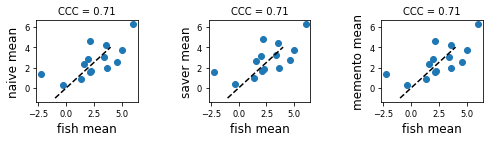

In [59]:
plt.figure(figsize=(8,1.5))
plt.subplots_adjust(wspace=0.7)

plt.subplot(1,3,1)
plt.scatter(np.log(means), np.log(naive_m/q))
plt.plot([-1, 4],[-1, 4], '--', color='k')
plt.xlabel('fish mean'); plt.ylabel('naive mean')
plt.title('CCC = '+str.format('{0:.2f}', stats.spearmanr(np.log(means), np.log(naive_m/q))[0]))

plt.subplot(1,3,2)
plt.scatter(np.log(means), np.log(saver_m/q))
plt.plot([-1, 4],[-1, 4], '--', color='k')
plt.xlabel('fish mean'); plt.ylabel('saver mean')
# print('saver', stats.pearsonr(fish_corr_array[selected_pairs], saver_corrs[selected_pairs])[0])
plt.title('CCC = '+str.format('{0:.2f}', stats.spearmanr(np.log(means), np.log(saver_m/q))[0]))

plt.subplot(1,3,3)
plt.scatter(np.log(means), np.log(dropseq_m*n_umi/q))
plt.plot([-1, 4],[-1, 4], '--', color='k')
plt.xlabel('fish mean'); plt.ylabel('memento fmean')
plt.title('CCC = '+str.format('{0:.2f}', stats.spearmanr(np.log(means), np.log(dropseq_m*n_umi/q))[0]))

plt.savefig('mean_comparisons.png', dpi=300)

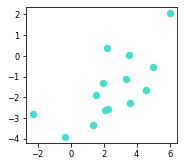

In [120]:
plt.figure(figsize=(2.7,2.5))
plt.scatter(np.log(means), np.log(dropseq_m), s=40, color='turquoise')
# plt.xlabel('smFISH log(CV)'); plt.ylabel('Dropseq log(CV)');
plt.savefig('mean_comparisons.pdf', bbox_inches='tight')

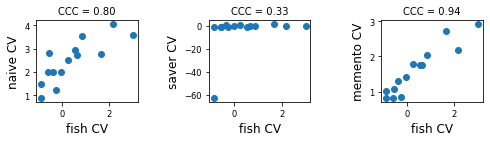

In [80]:
plt.figure(figsize=(8,1.5))
plt.subplots_adjust(wspace=0.7)

plt.subplot(1,3,1)
plt.scatter(np.log(fanos), np.log(naive_fano))
plt.xlabel('fish CV'); plt.ylabel('naive CV')
plt.title('CCC = '+str.format('{0:.2f}', stats.pearsonr(np.log(fanos), np.log(naive_fano))[0]))

plt.subplot(1,3,2)
plt.scatter(np.log(fanos), np.log(saver_fano))
plt.xlabel('fish CV'); plt.ylabel('saver CV')
# print('saver', stats.pearsonr(fish_corr_array[selected_pairs], saver_corrs[selected_pairs])[0])
plt.title('CCC = '+str.format('{0:.2f}', stats.pearsonr(np.log(fanos), np.log(saver_fano))[0]))

plt.subplot(1,3,3)
plt.scatter(np.log(fanos), np.log(dropseq_fano))
plt.xlabel('fish CV'); plt.ylabel('memento CV')
plt.title('CCC = '+str.format('{0:.2f}', stats.pearsonr(np.log(fanos), np.log(dropseq_fano))[0]))

plt.savefig('variability_comparisons.png', dpi=300)

In [122]:
result_path = '/data_volume/memento/saver/'

In [128]:
mean = pd.read_csv(result_path + 'dropseq_BASiCS_mu.csv'.format(q)).mean(axis=0)
delta = pd.read_csv(result_path + 'dropseq_BASiCS_delta.csv'.format(q)).mean(axis=0)
v_basics = mean+delta*mean**2
m_basics = mean
fano_basics = v_basics/m_basics**2

# scaling = (/m_basics)
# m_basics = m_basics*scaling
# v_basics = v_basics*scaling**2


In [137]:
print('memento', stats.pearsonr(np.log(fanos), np.log(dropseq_fano))[0])
print('naive', stats.pearsonr(np.log(fanos), np.log(naive_fano))[0])
print('basics', stats.pearsonr(np.log(fanos), np.log(fano_basics[overlap_genes]))[0])

memento 0.9405861170710372
naive 0.8048828841819847
basics 0.6088417637046718


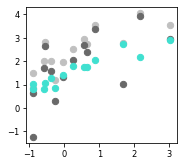

In [135]:
plt.figure(figsize=(2.7,2.5))
plt.scatter(np.log(fanos), np.log(naive_fano), s=40, color='silver')
plt.scatter(np.log(fanos), np.log(fano_basics[overlap_genes]), s=40, color='dimgrey')
plt.scatter(np.log(fanos), np.log(dropseq_fano), s=40, color='turquoise')

# plt.xlabel('smFISH log(CV)'); plt.ylabel('Dropseq log(CV)');
plt.savefig('variability_comparisons.pdf', bbox_inches='tight')

### Make comparison for correlations

In [82]:
saver_corrs = saver_corrs_all.loc[overlap_genes, overlap_genes].values.reshape(-1)

In [83]:
memento.compute_2d_moments(adata, gene_pairs=list(itertools.product(overlap_genes, overlap_genes)))

In [84]:
memento_corr_array = adata.uns['memento']['2d_moments']['sg^A']['corr']
memento_cov_array = adata.uns['memento']['2d_moments']['sg^A']['cov']

In [85]:
fish_corr_array = np.array([corrs.loc[x,y] for x,y in itertools.product(overlap_genes, overlap_genes)])
fish_cov_array = np.array([covs.loc[x,y] for x,y in itertools.product(overlap_genes, overlap_genes)])

In [86]:
selected_pairs = ~np.isnan(fish_corr_array) & (fish_corr_array!=1)

In [87]:
import matplotlib as mpl

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'large',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)


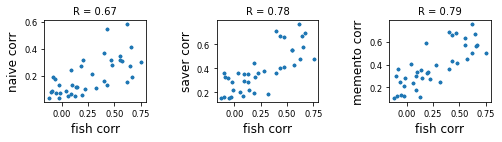

In [88]:
plt.figure(figsize=(8,1.5))
plt.subplots_adjust(wspace=0.7)

plt.subplot(1,3,1)
plt.scatter(fish_corr_array[selected_pairs], naive_corr.reshape(-1)[selected_pairs], s=7)
plt.xlabel('fish corr'); plt.ylabel('naive corr')
# print('naive', stats.pearsonr(fish_corr_array[selected_pairs], naive_corr.reshape(-1)[selected_pairs])[0])
plt.title('R = '+str(concordance(fish_corr_array[selected_pairs], naive_corr.reshape(-1)[selected_pairs])))
plt.title('R = '+str.format('{0:.2f}', stats.pearsonr(fish_corr_array[selected_pairs], naive_corr.reshape(-1)[selected_pairs])[0]))



plt.subplot(1,3,2)
plt.scatter(fish_corr_array[selected_pairs], saver_corrs[selected_pairs], s=7)
plt.xlabel('fish corr'); plt.ylabel('saver corr')
# print('saver', stats.pearsonr(fish_corr_array[selected_pairs], saver_corrs[selected_pairs])[0])
plt.title('R = '+str(concordance(fish_corr_array[selected_pairs], saver_corrs[selected_pairs])))
plt.title('R = '+str.format('{0:.2f}', stats.pearsonr(fish_corr_array[selected_pairs], saver_corrs[selected_pairs])[0]))

plt.subplot(1,3,3)
plt.scatter(fish_corr_array[selected_pairs], memento_corr_array[selected_pairs], s=7)
plt.xlabel('fish corr'); plt.ylabel('memento corr')
# print('memento', stats.pearsonr(fish_corr_array[selected_pairs], memento_corr_array[selected_pairs])[0])
plt.title('R = '+str.format('{0:.2f}', stats.pearsonr(fish_corr_array[selected_pairs], memento_corr_array[selected_pairs])[0]))

plt.savefig('coex_comparisons.png', dpi=300)

In [104]:
stats.pearsonr(fish_corr_array[selected_pairs], memento_corr_array[selected_pairs])[0]

0.7909050220217199

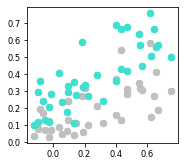

In [119]:
plt.figure(figsize=(2.7,2.5))
plt.scatter(fish_corr_array[selected_pairs], naive_corr.reshape(-1)[selected_pairs], s=40, color='silver')
plt.scatter(fish_corr_array[selected_pairs], memento_corr_array[selected_pairs], s=40, color='turquoise')
# plt.xlabel('smFISH corr'); plt.ylabel('Dropseq corr');
plt.savefig('correlation_comparisons.pdf', bbox_inches='tight')

### Investigate performance with varying number of UMIs per cell

In [ ]:
result = []
num_cell = 200
for p in [0.2, 0.35]:
        
        for trial in range(100):

            sample_idx = np.random.choice(dropseq.shape[0], num_cell)
            tiny = dropseq.iloc[sample_idx]
    
            shallow = pd.DataFrame(stats.binom.rvs(tiny, p=p), columns=tiny.columns)
            counts = shallow.sum(axis=0)[overlap_genes]
            relevant_genes = counts[counts > 0].index.tolist()
            shallow_sf = shallow.sum(axis=1).values
            mfish, m1, m2, m3, m4 = compare_estimators(smfish, fish_gapdh_sf, shallow, shallow_sf, overlap_genes=relevant_genes, p=1)

            mean_numi = shallow_sf.mean()
            
            try:
                corr1 = stats.pearsonr(np.log(mfish), np.log(m1))[0]
                corr2 = stats.pearsonr(np.log(mfish), np.log(m2))[0]
                corr3 = stats.pearsonr(np.log(mfish), np.log(m3))[0]
                corr4 = stats.pearsonr(np.log(mfish), np.log(m4))[0]
                result.append((num_cell, mean_numi, corr1, corr2, corr3, corr4))
            except:
                continue


In [79]:
experiment_result = pd.DataFrame(result, columns=['num_cell', 'mean_umi', 'naive', 'filtered', 'memento', 'pseudobulk'])
experiment_result['p'] = 0.2*(experiment_result['mean_umi'] < 600) + 0.35*(experiment_result['mean_umi'] >= 600)
experiment_result.to_csv('numi2.csv', index=False)

In [108]:
experiment_result = pd.concat(
    [
        pd.read_csv('numi.csv')[['num_cell', 'p','mean_umi', 'naive', 'filtered', 'memento']], 
        pd.read_csv('numi2.csv')[['num_cell', 'p','mean_umi', 'naive', 'filtered', 'memento']]])

In [109]:
df = pd.melt(experiment_result, id_vars=['num_cell', 'p'], value_vars=['memento','naive', ], var_name='estimator')

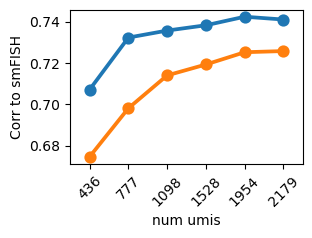

In [110]:
plt.figure(figsize=(3, 2))
sns.pointplot(y='value', x='p', hue='estimator',data=df, errorbar=('ci', 0), estimator='median')
plt.xlabel('num umis');plt.ylabel('Corr to smFISH')
plt.xticks(np.arange(6), experiment_result.groupby('p')['mean_umi'].mean().astype(int).values, rotation=45)
# sns.stripplot(y='value', x='p', hue='estimator',data=df, dodge=True, alpha=0.2,s=3)
plt.legend([], frameon=False)

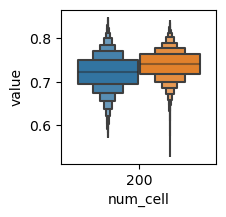

In [50]:
plt.figure(figsize=(2, 2))
sns.boxenplot(y='value', x='num_cell', hue='estimator',data=df, showfliers=False, k_depth=10)
# sns.stripplot(y='value', x='p', hue='estimator',data=df, dodge=True, alpha=0.2,s=3)
plt.legend([], frameon=False)

In [223]:
tiny = dropseq.iloc[sample_idx]
tiny_sf = dropseq_sf[sample_idx]
mfish, m1, m2, m3 = compare_estimators(smfish, fish_gapdh_sf, tiny, tiny_sf)

p=0.1
shallow = pd.DataFrame(stats.binom.rvs(tiny, p=p), columns=dropseq.columns)
shallow_sf = shallow.sum(axis=1).values
mfish, m1, m2, m3 = compare_estimators(smfish, fish_gapdh_sf, shallow, shallow_sf, p=p)

plt.scatter(x=np.log(mfish), y=np.log(m1))
plt.scatter(x=np.log(mfish), y=np.log(m2))
plt.scatter(x=np.log(mfish), y=np.log(m3))

plt.xlabel('FISH'); plt.ylabel('Dropseq');
plt.legend(['naive r=%0.2f' % stats.pearsonr(np.log(mfish), np.log(m1))[0], 
            'filtered r=%0.2f' %stats.pearsonr(np.log(mfish), np.log(m2))[0], 
            'weighted r=%0.2f' %stats.pearsonr(np.log(mfish), np.log(m3))[0],
           ])

TypeError: compare_estimators() missing 1 required positional argument: 'overlap_genes'